## Ziele
Festlegung der Zielgroesse: PCR Platte, spezifisch, wird in kontaminierte Platte (Platte 1) und nicht kontaminierte Platte unterschieden. Ziel ist es mit einem ueberwachtem Lernverfahren vorherzusagen, ob eine Platte kontaminiert sein wird.
Falls das mit annehmbarer Accuracy vorherzusagen ist, interessieren mich vor Allem die Features, die wichtig fuer die Vorhersage sind. Daraus erhoffe ich mir herauszufinden welche Variablen fuer die Kontamination verantwortlich sind / waren. Es handelt sich um eine Klassifikationsaufgabe

## Ziele Bullet Points
* What went wrong with the contaminated PCR Plate
* Can we predict the contaminated PCR Plate
* Are there specific contaminations

## Implementation
* Use Random Forest to predict PCR Plate (1 and other)
* Check Accuracy
- Use RF Feature Importance to find factors that contribute to contamination
- Use Shapley Value to find factors that contribute to contamination


In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import shap

import pprint
import statistics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV

np.random.seed(0)



%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,4)

pd.options.mode.chained_assignment = None
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# read data
meta_df = pd.read_csv("../data/output/preprocessed_data.csv",  index_col=0)
seq_df = pd.read_csv("../data/output/seqData.csv", index_col = 0)
seq_df_two = pd.read_csv("../data/output/seqData.csv", index_col = 0) # helper
otu_info = pd.read_csv("../data/output/otu_info.csv")

otu_info_helper = otu_info.rename(index = otu_info.otu)
otu_info_helper = otu_info_helper.transpose()
whole_meta_df = pd.read_csv("../data/output/whole_preprocessed_meta_data", index_col = 0)
whole_meta_df["PCR_plate"].value_counts(dropna=False)


1    93
2    91
3    15
Name: PCR_plate, dtype: int64

## Task 0: Prepare Data specifically for supervised models
I want to classify the count data as well as the metadata based on if the pcr plate was contamined. Therefore, I aggregate the information about the PCR plate of the sample into two groups: contamined (plate 1) and not contamined(plates 2,3). The contamined plates are encoded with a 1, the non-contamined plates with a 0.
Subsequently, I will save the target variable (contamined, not contamined) as an extra vector an remove it from the dataframe we train and test with. I will perform to analyses: The main analysis will use the OTU Counts as features to predict if the plate will be contamined. If the predictions work with sufficient accuracy, I will investigate which OTUs have the highest influence on the prediction. I will perform the same anlayses with the metadata.

In [3]:

# Modify target variable
meta_df = meta_df.assign(
    is_contamined = lambda dataframe: dataframe['PCR_plate'].map(lambda PCR_plate: 1 if PCR_plate == 1 else 0) 
)
meta_df = meta_df.drop(columns=["PCR_plate"])




In [4]:
whole_meta_df = whole_meta_df.assign(
    is_contamined = lambda dataframe: dataframe['PCR_plate'].map(lambda PCR_plate: 1 if PCR_plate == 1 else 0) 
)
whole_meta_df = whole_meta_df.drop(columns=["PCR_plate"])

In [5]:
whole_meta_df.is_contamined.dtypes


dtype('int64')

In [6]:

meta_df.head()
whole_meta_df.head()

,Rearing_LAB,Sex,Age_weeks,Animals_for,cage_ID,BOX,Position,sample_type,extraction_date,extraction_run,...,tail_handling,BW_g,BW1_g,BW2_g,BW3_g,BW4_g,BW5_g,Notes,median_count,is_contamined
100A,LAB_3,F,14.0,behaviour,BF4,3.0,17.0,primary,29/5/2020,15.0,...,no,NaN,19.1,20.5,20.3,21.1,21.8,NaN,0.0,0
100B,LAB_3,F,14.0,gene_expr,BF4,2.0,17.0,primary,14/5/2020,8.0,...,no,NaN,19.2,20.7,21.1,22.2,23.4,NaN,0.0,1
101A,LAB_4,F,14.0,gene_expr,MF7,2.0,23.0,primary,14/5/2020,8.0,...,yes,NaN,17.0,20.1,19.9,19.8,21.1,NaN,0.0,1
101B,LAB_4,F,14.0,behaviour,MF7,3.0,23.0,primary,2/6/2020,16.0,...,yes,NaN,15.5,17.8,18.0,18.5,18.9,NaN,0.0,0
103A,LAB_4,F,14.0,behaviour,MF2,3.0,19.0,primary,2/6/2020,16.0,...,yes,NaN,16.0,18.4,18.3,17.9,19.1,NaN,0.0,0


In [7]:
meta_df.shape

(173, 42)



## Task 1:  split data in test and validation data
Therefore I use a custom function to have balanced classes, as mentioned before my target variable ist if the plate was contaminied

In [8]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n%s:\n---------\ntotal:%d\ntrain_df:%d\ntest_df:%d' % (lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)

    return train_df, test_df

In [9]:
whole_meta_df.shape

(199, 61)

In [10]:
meta_df.shape

(173, 42)

In [11]:
train_df_meta, test_df_meta = split_to_train_test(meta_df, "is_contamined",0.7)
seq_df_and_target = seq_df_two
seq_df_and_target["is_contamined"] = whole_meta_df.is_contamined
train_df_counts, test_df_counts = split_to_train_test(seq_df_and_target, "is_contamined", 0.7)
seq_df_and_target.shape


0:
---------
total:90
train_df:63
test_df:27

1:
---------
total:83
train_df:58
test_df:25

0:
---------
total:106
train_df:74
test_df:32

1:
---------
total:93
train_df:65
test_df:28


(199, 1565)

In [12]:
# Check Class Balance to select suitable evaluation metric
meta_df.is_contamined.value_counts()


0    90
1    83
Name: is_contamined, dtype: int64

## Task 2: Select a evaluation metric
For my first analyses I will chose the Accuracy as defined: Accuracy = (TP+TN)/(TP+FP+FN+TN) as a metric. It is a well established metric for a two class classification problem and since we have equally balanced classes it is a reasonable choice

## Task 3: Create a baseline model
Since I have a two class classification problem with balanced classes, it is suitable to chose the relative frequency of the more frequent class as naive baseline prediction accuracy.


In [13]:
# baseline estimation

freq_class = max(meta_df.is_contamined.value_counts())
baseline = freq_class / len(meta_df.index)
print("Baseline Estimation ${}".format(baseline))

Baseline Estimation $0.5202312138728323


## Task 4: Build a decision tree model
Use a decisoin tree as a very simple supervised method to see if more complex models are justified

In [14]:


# function that returns predictions of a Decision Tree
# takes whole dataframe including the target variable as input
def train_dec_tree(df, target):
    
    # prepare data
    y_train = df.loc[:, target]
    X_train = df.drop(columns=[target])
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier()

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    return clf




### Decision Tree for count data

In [15]:
clf_count_data = train_dec_tree(train_df_counts, "is_contamined")
clf_count_data.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [16]:
count_pred = clf_count_data.predict(test_df_counts.drop(columns=["is_contamined"]))
metrics.accuracy_score(test_df_counts.is_contamined, count_pred)
clf_report_dt_count = metrics.classification_report(test_df_counts.is_contamined, count_pred)
pp.pprint(clf_report_dt_count)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.71      0.62      0.67        32\n'
 '           1       0.62      0.71      0.67        28\n'
 '\n'
 '    accuracy                           0.67        60\n'
 '   macro avg       0.67      0.67      0.67        60\n'
 'weighted avg       0.67      0.67      0.67        60\n')


### Decision Tree count data cross validation

In [17]:
## train / test with crossvalidation

dtc  = DecisionTreeClassifier()
scores_prec = cross_val_score(dtc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='precision')
scores_acc = cross_val_score(dtc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='accuracy')
scores_recall = cross_val_score(dtc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='recall')
scores_f1 = cross_val_score(dtc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='f1')

In [18]:
print(statistics.mean(scores_prec),statistics.stdev(scores_prec))
print(statistics.mean(scores_acc), statistics.stdev(scores_acc))
print(statistics.mean(scores_recall), statistics.stdev(scores_recall))
print(statistics.mean(scores_f1), statistics.stdev(scores_f1))

0.5941803539597658 0.163970357898921
0.6573684210526316 0.13459582349870045
0.6277777777777778 0.27732061145243275
0.5762257431400655 0.23162750125272416


### Decision Tree for meta data

In [19]:
clf_meta_data = train_dec_tree(train_df_meta, "is_contamined")
meta_pred = clf_meta_data.predict(test_df_meta.drop(columns=["is_contamined"]))
metrics.accuracy_score(test_df_meta.is_contamined, meta_pred)
clf_report_dt_meta = metrics.classification_report(test_df_meta.is_contamined, meta_pred)
pp.pprint(clf_report_dt_meta)



('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00        27\n'
 '           1       1.00      1.00      1.00        25\n'
 '\n'
 '    accuracy                           1.00        52\n'
 '   macro avg       1.00      1.00      1.00        52\n'
 'weighted avg       1.00      1.00      1.00        52\n')


## Task 5: Use a supervised machine learning model
I have two objectives: Firstly, I want to find out what is distinctive for samples that were one the contamined plate 1. Therefore I am not so much interested in the prediction itself, rather then the features that are important for the prediction. So for the first question I use a random forest model and extract the feature importance. Additionally, I will use the shapley value to assess feature importance.

Secondly, I am interested if it is possible to predict on which plate the contamination was. Therefore, I use the above-trained Random Forest model and baselines classifiers. Additionally, I will train a Mulit Layer Perceptron and Cross Validation to predict the plate.

In [20]:

# functions that return predictions of a Random Forest
def train_test_rf(df, target):
    
    # prepare data
    y_train = df.loc[:, target]
    X_train = df.drop(columns=[target])
    
    clf = RandomForestClassifier(n_estimators=200, random_state=1)
    clf = clf.fit(X_train, y_train)
  
    return clf

In [21]:
## train / test with crossvalidation
rfc = RandomForestClassifier(n_estimators=200, random_state=1)
# rfc = DecisionTreeClassifier()
scores_prec = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='precision')
scores_acc = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='accuracy')
scores_recall = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='recall')
scores_f1 = cross_val_score(rfc, seq_df, seq_df_and_target.is_contamined, cv = 10, scoring='f1')

In [22]:
print(statistics.mean(scores_prec),statistics.stdev(scores_prec))
print(statistics.mean(scores_acc), statistics.stdev(scores_acc))
print(statistics.mean(scores_recall), statistics.stdev(scores_recall))
print(statistics.mean(scores_f1), statistics.stdev(scores_f1))

0.826388888888889 0.14966383226623103
0.7481578947368421 0.09943708909454352
0.6611111111111111 0.27593214012390943
0.6798984641089905 0.19842591940602117


In [23]:
# prints accuracy and displays confusion table as heatmap
def accurcay_confusion_heatmap(test_df, predictions, target):
    conf_mat = confusion_matrix(test_df.loc[:,target], predictions)
    print(conf_mat)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(test_df.loc[:,target], predictions))
    # helper df for heatmap
    df_cm = pd.DataFrame(conf_mat, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 4}) # font size

    plt.show()

### Supervised model for count data

In [24]:
count_rf_clf = train_test_rf(train_df_counts, "is_contamined")
count_pred_rf = count_rf_clf.predict(test_df_counts.drop(columns=["is_contamined"]))

rf_default_values = count_rf_clf.get_params()
rf_default_values

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [25]:
clf_report_count = metrics.classification_report(test_df_counts.is_contamined, count_pred_rf)
pp.pprint(clf_report_count)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.84      0.97      0.90        32\n'
 '           1       0.96      0.79      0.86        28\n'
 '\n'
 '    accuracy                           0.88        60\n'
 '   macro avg       0.90      0.88      0.88        60\n'
 'weighted avg       0.89      0.88      0.88        60\n')


[[31  1]
 [ 6 22]]
Accuracy: 0.8833333333333333


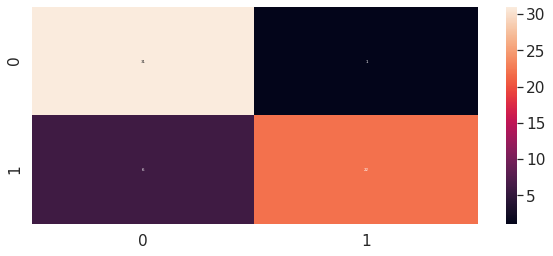

In [26]:
accurcay_confusion_heatmap(test_df_counts, count_pred_rf, "is_contamined")

### Supervised model for meta data

In [27]:
meta_rf_clf = train_test_rf(train_df_meta, "is_contamined")
meta_pred_rf = meta_rf_clf.predict(test_df_meta.drop(columns=["is_contamined"]))
metrics.accuracy_score(test_df_meta.is_contamined, meta_pred_rf)
clf_report_rf_meta = metrics.classification_report(test_df_meta.is_contamined, meta_pred_rf)
pp.pprint(clf_report_rf_meta)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00        27\n'
 '           1       1.00      1.00      1.00        25\n'
 '\n'
 '    accuracy                           1.00        52\n'
 '   macro avg       1.00      1.00      1.00        52\n'
 'weighted avg       1.00      1.00      1.00        52\n')



## Task 5.1

To get a insight what was differnt on the contamined plates, respectively which features contributet to the contamination, I now investigate the feature importance of the RF.

In [28]:
def plt_feat_importance(clf, target_var, features):
    
    feat_importances = pd.Series(clf.feature_importances_, index=features)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.xlabel("Mean Decrease Impurity", fontsize = 18)

    return feat_importances

In [29]:
otu_info_helper.head()

,otu1,otu2,otu3,otu4,otu5,otu6,otu7,otu8,otu9,otu10,...,otu1555,otu1556,otu1557,otu1558,otu1559,otu1560,otu1561,otu1562,otu1563,otu1564
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563
otu,otu1,otu2,otu3,otu4,otu5,otu6,otu7,otu8,otu9,otu10,...,otu1555,otu1556,otu1557,otu1558,otu1559,otu1560,otu1561,otu1562,otu1563,otu1564
seq,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCG...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCT...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,...,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,CGTCGGCAGCGTCAGATGTGTATAAGAGACAGTGCAGGTGCCAGCA...,TACGGAGGATGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGGG...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGGG...,TACGTAGGGGGCAAGCGTTATCCGGATTCACTGGGCGTAAAGGGAG...,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,TACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGAGGATTCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGTGTAAAGGGAG...,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...
tax,rootrank;Root;62.12|domain;Bacteria;62.12|phyl...,rootrank;Root;100|domain;Bacteria;100|phylum;F...,rootrank;Root;72.8|domain;Bacteria;72.8|phylum...,rootrank;Root;98.27|domain;Bacteria;98.27|phyl...,rootrank;Root;100|domain;Bacteria;100|phylum;F...,rootrank;Root;57.53|domain;Bacteria;57.53|phyl...,rootrank;Root;64.9|domain;Bacteria;64.44|phylu...,rootrank;Root;66.29|domain;Bacteria;66.29|phyl...,rootrank;Root;67.98|domain;Bacteria;67.98|phyl...,rootrank;Root;100|domain;Bacteria;100|phylum;F...,...,rootrank;Root;62.98|domain;Bacteria;62.98|phyl...,rootrank;Root;48.03|domain;Bacteria;45.85|phyl...,rootrank;Root;68.61|domain;Bacteria;68.61|phyl...,rootrank;Root;75.6|domain;Bacteria;75.6|phylum...,rootrank;Root;83.43|domain;Bacteria;83.43|phyl...,rootrank;Root;58.62|domain;Bacteria;58.62|phyl...,rootrank;Root;60.66|domain;Bacteria;60.66|phyl...,rootrank;Root;64.48|domain;Bacteria;64.48|phyl...,rootrank;Root;68.38|domain;Bacteria;68.38|phyl...,rootrank;Root;74.04|domain;Bacteria;74.04|phyl...


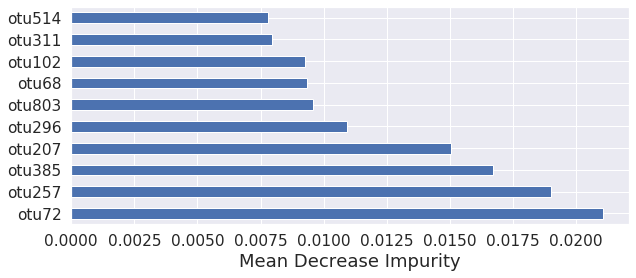

In [30]:
# plot feature importance for count data
importance = plt_feat_importance(count_rf_clf, "is_contamined", otu_info_helper.columns)


otu1       0.002344
otu2       0.000714
otu3       0.001829
otu4       0.000772
otu5       0.000174
             ...   
otu1560    0.000000
otu1561    0.000000
otu1562    0.000000
otu1563    0.000000
otu1564    0.000000
Length: 1564, dtype: float64

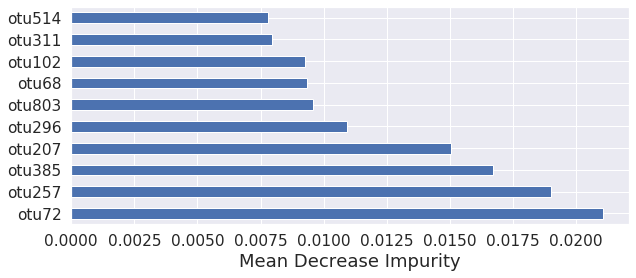

In [31]:

plt_feat_importance(count_rf_clf, "is_contamined", otu_info_helper.columns)

In [32]:


meta_df.columns

Index(['Rearing_LAB ', 'Age_weeks', 'sample_type', 'extraction_date',
       'extraction_run', 'extracted_by', 'DNA_elution_Vol_ul',
       'Quantification_method', 'DNA_conc_ng_ul', '260 / 280', '230 / 260',
       '16S_PCR_date', 'PCR_row', 'PCR_position', 'library_conc_ng_ul',
       'FA_kit_used', 'repeat_library_prep', 'library_prep_attempt',
       'Use_for_pooling', 'Dilution_factor', 'Vol_EB_ul', 'Vol_DNA_ul',
       'light_cycle', 'cage_type', 'bedding_material', 'bedding_autoclaved',
       'house_present', 'roll_present', 'enrichment_autoclaved', 'diet',
       'diet_treatment', 'water_autoclaved', 'water_chlorinated',
       'mean_room_temp_C', 'room_humidity', 'other_animals_present',
       'other_animals_present_kind', 'housing_room_condition', 'tail_handling',
       'Notes', 'median_count', 'is_contamined'],
      dtype='object')

Rearing_LAB                   0.000596
Age_weeks                     0.055136
sample_type                   0.000000
extraction_date               0.032872
extraction_run                0.180911
extracted_by                  0.002316
DNA_elution_Vol_ul            0.075648
Quantification_method         0.023723
DNA_conc_ng_ul                0.009897
260 / 280                     0.006053
230 / 260                     0.004123
16S_PCR_date                  0.200370
PCR_row                       0.005315
PCR_position                  0.003097
library_conc_ng_ul            0.016408
FA_kit_used                   0.116323
repeat_library_prep           0.000000
library_prep_attempt          0.235171
Use_for_pooling               0.000000
Dilution_factor               0.010955
Vol_EB_ul                     0.011011
Vol_DNA_ul                    0.000000
light_cycle                   0.000042
cage_type                     0.000900
bedding_material              0.000503
bedding_autoclaved       

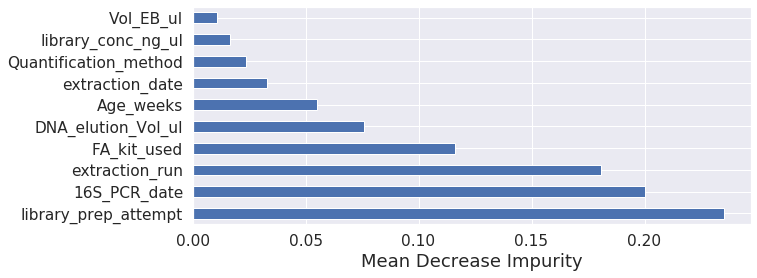

In [33]:
# plot feature importance for meta data
plt_feat_importance(meta_rf_clf, "is_contamined", meta_df.drop(columns=["is_contamined"]).columns)

## Shapley Value for feature contribution
// TODO describe


In [34]:

def plot_shap_val(clf, X_train):
    
    shap_obj  = shap.TreeExplainer(clf)
    shap_values = shap_obj.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)
    return shap_obj

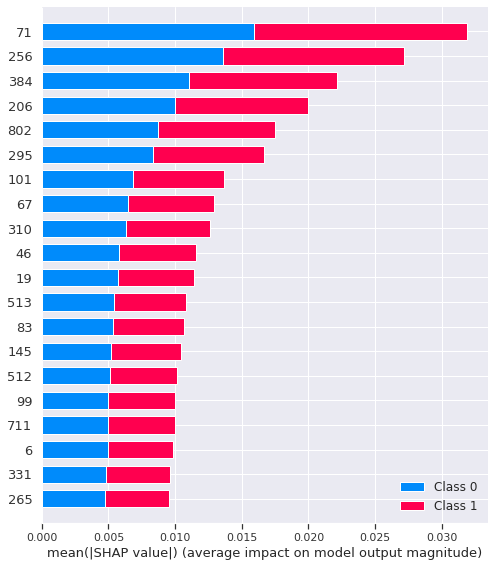

In [35]:
# get shapley values for count data and plot
count_shap_vals = plot_shap_val(count_rf_clf, train_df_counts)



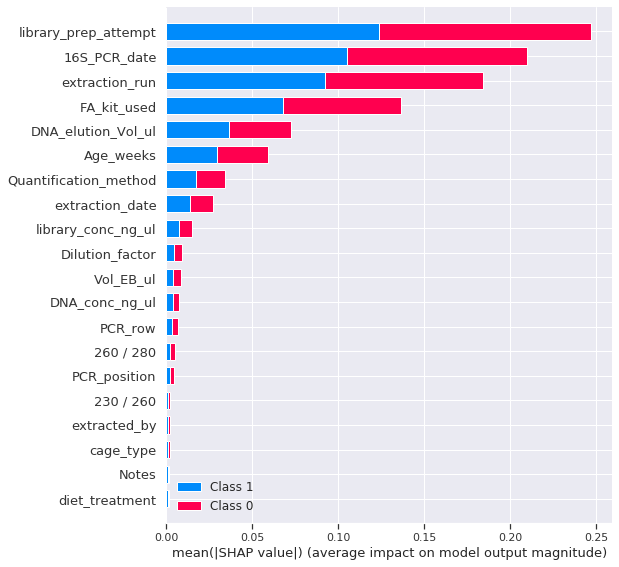

In [36]:
# geth shapley values and plot for meta data
count_meta_vals = plot_shap_val(meta_rf_clf, train_df_meta)

## Task 5.2 Multi Layer Perceptron
Before I train the model, I need to scale the data (this was not necessary for the Random Forest, because it can deal with unscaled data). I did this during preprocessing and only need to load the data

In [37]:
scaled_df = pd.read_csv("../data/output/scaled_seq.csv")


In [38]:
scaled_df.shape

(199, 1565)

In [39]:
meta_df.shape

(173, 42)

In [40]:
model = MLPClassifier() 

is_contamined.index = range(len(is_contamined))
scaled_df.index = range(len(scaled_df))
scaled_df = scaled_df.drop(scaled_df.columns[0], axis=1)

# cv_results = cross_validate(model,scaled_df, is_contamined, cv=10, 
#                             return_train_score=False, 
#                             scoring=model.score) 
# print("Fit scores: {}".format(cv_results['test_score']))

kf = StratifiedKFold(n_splits=10)
clf = MLPClassifier()
score_list = []
report_list = []
for train_indices, test_indices in kf.split(scaled_df, seq_df_and_target.is_contamined):
    clf.fit(scaled_df.iloc[train_indices,:], is_contamined[train_indices])
    pred = clf.predict(scaled_df.iloc[test_indices,:])
    print(pred)
    cur_report = metrics.classification_report(pred, is_contamined[test_indices])
    cur_score = clf.score(scaled_df.iloc[test_indices,:], is_contamined[test_indices])
    score_list.append(cur_score)
    report_list.append(cur_report)
    pp.pprint(cur_report)
    print(cur_score)

NameError: name 'is_contamined' is not defined

### Better way to Cross validate fount
I use now cross_val_score from sckit learn


In [ ]:
mlp_untuned = MLPClassifier()

In [ ]:
scores_prec = cross_val_score(mlp_untuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='precision')
scores_acc = cross_val_score(mlp_untuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='accuracy')
scores_recall = cross_val_score(mlp_untuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='recall')
scores_f1 = cross_val_score(mlp_untuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='f1')

In [ ]:
print(statistics.mean(scores_prec),statistics.stdev(scores_prec))
print(statistics.mean(scores_acc), statistics.stdev(scores_acc))
print(statistics.mean(scores_recall), statistics.stdev(scores_recall))
print(statistics.mean(scores_f1), statistics.stdev(scores_f1))

In [ ]:
clf.get_params()

## MLP with parameter tuning

In [ ]:
# mlp = MLPClassifier(max_iter=500, random_state=0)
# parameter_space = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#       'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#     'alpha': [0.0001, 0.01, 0.05, 0.1],
#     'learning_rate': ['constant','adaptive'], 
# }
# clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=10)
# clf.fit(scaled_df, seq_df_and_target.is_contamined)

# # Best paramete set
# print('Best parameters found:\n', clf.best_params_)


### MLP with tuned parameter


In [ ]:
mlp_tuned = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100,50,100), learning_rate='constant',
                         solver='lbfgs', random_state=0, max_iter=500)
scores_prec = cross_val_score(mlp_tuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='precision')
scores_acc = cross_val_score(mlp_tuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='accuracy')
scores_recall = cross_val_score(mlp_tuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='recall')
scores_f1 = cross_val_score(mlp_tuned, scaled_df, seq_df_and_target.is_contamined, cv = 10, scoring='f1')

In [ ]:
print(statistics.mean(scores_prec),statistics.stdev(scores_prec))
print(statistics.mean(scores_acc), statistics.stdev(scores_acc))
print(statistics.mean(scores_recall), statistics.stdev(scores_recall))
print(statistics.mean(scores_f1), statistics.stdev(scores_f1))

## Result Analyse
I will create boxplots of the most important and least important otus

In [41]:
most_important = importance.nlargest(10)
most_important_names = list(most_important.index)
most_important_ind = [int(x[3:]) for x in most_important_names]
most_important_ind

[72, 257, 385, 207, 296, 803, 68, 102, 311, 514]

In [42]:
least_important = importance.nsmallest(10)
least_important

otu22     0.0
otu98     0.0
otu147    0.0
otu183    0.0
otu191    0.0
otu201    0.0
otu220    0.0
otu231    0.0
otu233    0.0
otu261    0.0
dtype: float64

In [43]:
least_important_names = list(least_important.index)
least_important_ind = [int(x[3:]) for x in least_important_names]
least_important_ind

[22, 98, 147, 183, 191, 201, 220, 231, 233, 261]

In [44]:
seq_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563
100A,121182,0,9921,1351,65360,24331,3858,15493,373,1911,...,0,0,0,0,0,0,0,0,0,0
100B,51332,0,5047,97217,245,5078,1564,8653,2739,2879,...,0,0,0,0,0,0,0,0,0,0
101A,47276,250,27034,917,32350,11503,6836,26665,9471,286,...,0,0,0,0,0,0,0,0,0,0
101B,35653,0,25285,145,41464,16648,4978,20689,8220,281,...,0,0,0,0,0,0,0,0,0,0
103A,90972,962,1765,93,188,16078,12066,20746,15073,38305,...,0,0,0,0,0,0,0,0,0,0


In [45]:
least_important_df = seq_df.iloc[:,least_important_ind]
most_important_df = seq_df.iloc[:,most_important_ind]

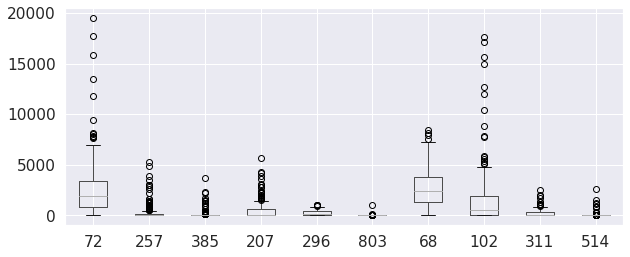

In [46]:
most_important_df.boxplot()

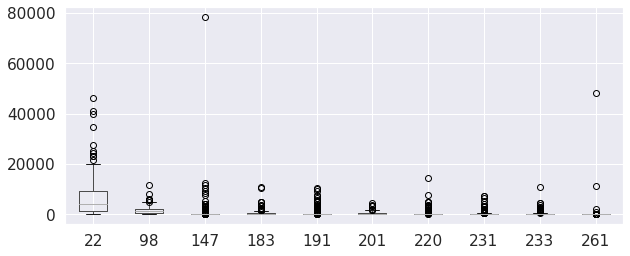

In [47]:
least_important_df.boxplot()

22.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
64.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
81.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
79.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
78.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
83.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
81.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
82.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
82.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
90.5% of the points cannot be placed; you may want to d

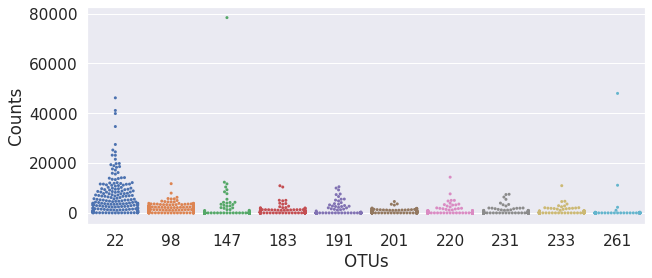

In [48]:
# f, ax = plt.subplots()
# ax.set(yscale="log")

sns.swarmplot(x = "OTUs", y = "Counts",data = pd.melt(least_important_df,
                                            var_name="OTUs", value_name="Counts"), s = 3)


12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
70.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
82.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
59.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
74.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
92.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
73.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
87.4% of the points cannot be placed; you may want to de

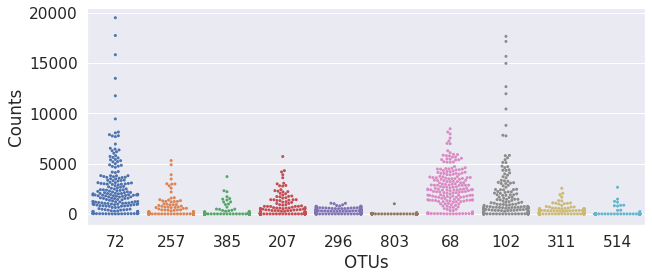

In [51]:
# f, ax = plt.subplots()
# ax.set(yscale="log")

sns.swarmplot(x = "OTUs", y = "Counts",data = pd.melt(most_important_df,
                                            var_name="OTUs", value_name="Counts"), s = 3)


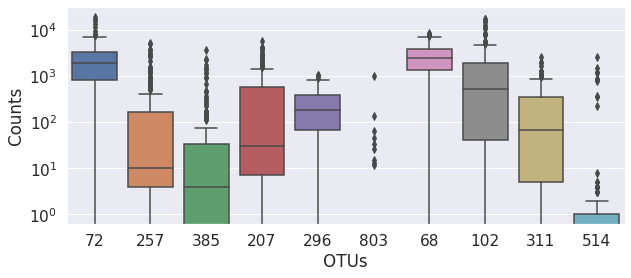

In [52]:
f, ax = plt.subplots()
ax.set(yscale="log")

sns.boxplot(x = "OTUs", y = "Counts",data = pd.melt(most_important_df,
                                            var_name="OTUs", value_name="Counts"))

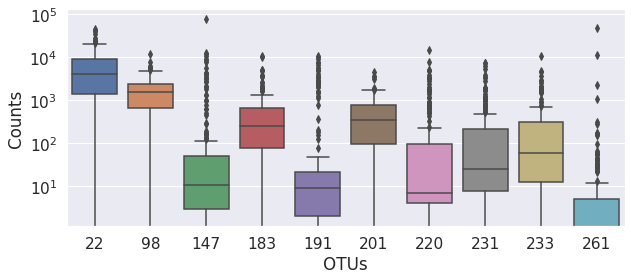

In [53]:
f, ax = plt.subplots()
ax.set(yscale="log")

sns.boxplot(x = "OTUs", y = "Counts",data = pd.melt(least_important_df,
                                            var_name="OTUs", value_name="Counts"))

## Resulta analysis 1
check boxplots of contaminated vs non-contaminated samples for the most important OTUs


In [54]:
most_important_ind
most_important_df["is_contamined"] = seq_df_and_target.is_contamined
least_important_df["is_contamined"] = seq_df_and_target.is_contamined

In [56]:
plot_df = most_important_df.drop(columns=["is_contamined"]).stack().reset_index()
plot_df_least = least_important_df.drop(columns=["is_contamined"]).stack().reset_index()

In [57]:
most_important_df["level_0"] = most_important_df.index
least_important_df["level_0"] = least_important_df.index

In [58]:

newplot_df  = plot_df.level_0.map(most_important_df.is_contamined)
newplot_df_least  = plot_df_least.level_0.map(least_important_df.is_contamined)

In [59]:
newplot_df

0       0
1       0
2       0
3       0
4       0
       ..
1985    1
1986    1
1987    1
1988    1
1989    1
Name: level_0, Length: 1990, dtype: int64

In [60]:
plot_df["is_contamined"] = newplot_df
plot_df_least["is_contamined"] = newplot_df_least

In [61]:
plot_df.head()
plot_df.columns = ["sampleId", "OTUs", "Counts", "is_contaminated"]
plot_df_least.columns = ["sampleId", "OTUs", "Counts", "is_contaminated"]

In [62]:
newplot_df

0       0
1       0
2       0
3       0
4       0
       ..
1985    1
1986    1
1987    1
1988    1
1989    1
Name: level_0, Length: 1990, dtype: int64

In [63]:
plot_df

,sampleId,OTUs,Counts,is_contaminated
0,100A,72,90,0
1,100A,257,5,0
2,100A,385,0,0
3,100A,207,1750,0
4,100A,296,85,0
...,...,...,...,...
1985,S9,803,0,1
1986,S9,68,1352,1
1987,S9,102,77,1
1988,S9,311,140,1


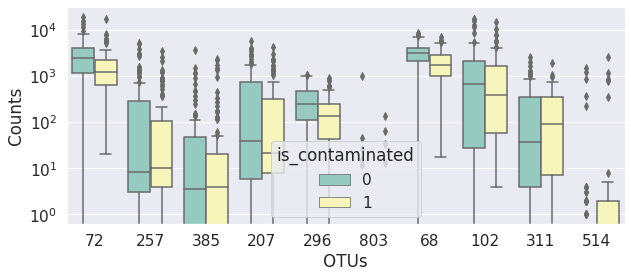

In [64]:
## boxplot compare important OTUS from contaminated and not contaminated samples
f, ax = plt.subplots()
ax.set(yscale="log")
ax = sns.boxplot(x="OTUs", y="Counts", hue="is_contaminated",              
data=plot_df, palette="Set3")

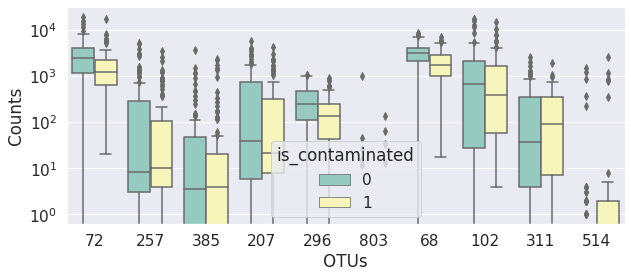

In [67]:
f, ax = plt.subplots()
ax.set(yscale="log")
ax = sns.boxplot(x="OTUs", y="Counts", hue="is_contaminated",              
data=plot_df, palette="Set3")

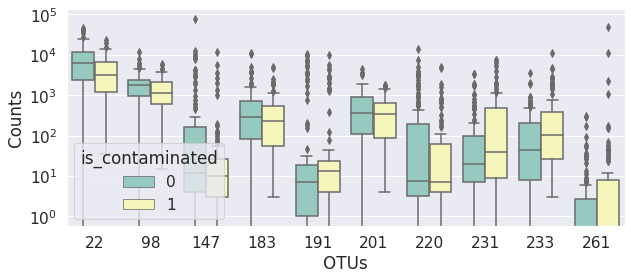

In [66]:
## boxplot compare non important OTUS from contaminated and not contaminated samples
f, ax = plt.subplots()
ax.set(yscale="log")
ax = sns.boxplot(x="OTUs", y="Counts", hue="is_contaminated",              
data=plot_df_least, palette="Set3")

In [68]:
important_tax = otu_info.iloc[most_important_ind,3]

In [69]:
important_tax.iloc[1].split(';')[-2]

'unclassified_Lachnospiraceae'

In [70]:
for i in range(len(important_tax)):
    cur_tax = important_tax.iloc[i].split(';')[-2]
    print(cur_tax, important_tax.index[i])

unclassified_Bacteroidales 72
unclassified_Lachnospiraceae 257
Lachnospiraceae UCG-006 385
Lachnospiraceae NK4A136 group 207
Enterorhabdus 296
Blautia 803
unclassified_Bacteroidales 68
Lactobacillus 102
unclassified_Lachnospiraceae 311
unclassified_Bacteroidales 514


In [ ]:
important_tax

In [ ]:
for i in important_tax.index:
    print(type(i))